Output()

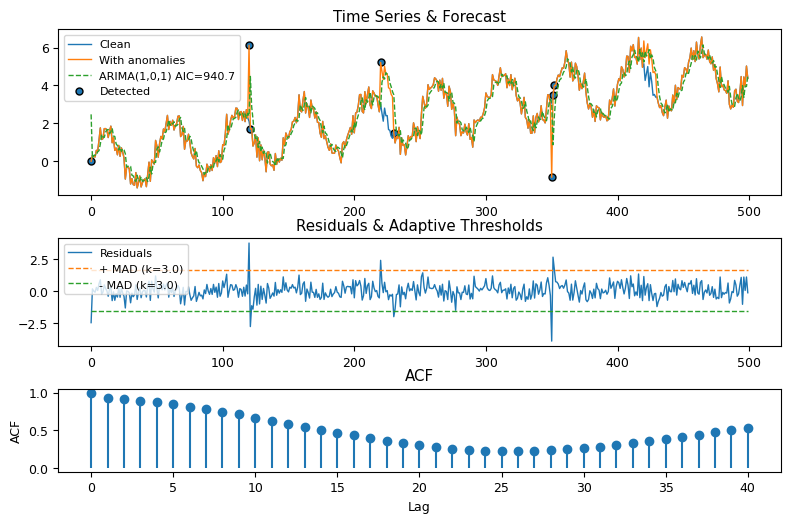

In [2]:
# If needed:
# !pip install ipywidgets statsmodels
# Optional (for LSTM):
# !pip install torch -q

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import (
    Dropdown, FloatSlider, IntSlider, Checkbox, VBox, HBox,
    Layout, Label, Output
)
from IPython.display import display, clear_output
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL

# ---- optional torch (for LSTM)
try:
    import torch
    from torch import nn
    TORCH_OK = True
except Exception:
    TORCH_OK = False

# ---------------- Generators & utilities ----------------
def synth_series(n=500, seed=7, trend_slope=0.01, season_amp=1.5, season_period=50, noise_sigma=0.4):
    rng = np.random.default_rng(seed)
    t = np.arange(n)
    trend = trend_slope * t
    season = season_amp * np.sin(2*np.pi*t/max(2, season_period)) if season_period>0 else 0*t
    noise = noise_sigma * rng.standard_normal(n)
    x = trend + season + noise
    return t, x

def inject_anomalies(x, enable_point=True, point_mag=4.0,
                     enable_coll=True, coll_start=220, coll_len=10, coll_mag=2.2,
                     enable_ctxt=True, ctxt_start=420, ctxt_len=10, ctxt_mag=1.2):
    x = x.copy()
    n = len(x)
    if enable_point:
        for p, m in zip([120, 350], [point_mag, -point_mag]):
            if 0 <= p < n: x[p] += m
    if enable_coll:
        s = int(np.clip(coll_start, 0, n-1)); e = int(np.clip(s+coll_len, 0, n))
        if s < e: x[s:e] += coll_mag
    if enable_ctxt:
        s = int(np.clip(ctxt_start, 0, n-1)); e = int(np.clip(s+ctxt_len, 0, n))
        if s < e: x[s:e] += ctxt_mag
    return x

def rolling_mean_std(a, win):
    win = max(2, int(win))
    c = np.cumsum(np.insert(a, 0, 0.0))
    m = (c[win:] - c[:-win]) / win
    padm = np.concatenate([np.full(win-1, m[0]), m])
    v = []
    for i in range(len(a)):
        s = max(0, i-win+1); e = i+1
        v.append(a[s:e].std(ddof=0))
    return padm, np.array(v)

def mad_scale(resid):
    med = np.median(resid)
    mad = np.median(np.abs(resid - med)) + 1e-12
    # 1.4826*MAD ~ sigma for normal
    return med, 1.4826 * mad

# ---------------- Models ----------------
def fit_predict_model(x, model_type, p=1, d=0, q=0,
                      lstm_steps=10, lstm_hidden=16, lstm_epochs=10, lstm_lr=1e-2, seed=7):
    """
    Returns predictions aligned to x (one-step-ahead), and a string describing the fit.
    AR -> use ARIMA(p,0,0)
    MA -> use ARIMA(0,0,q)
    ARIMA -> ARIMA(p,d,q)
    LSTM -> sequence-to-one simple model (if torch installed)
    """
    n = len(x)
    desc = ""
    if model_type in ("AR", "MA", "ARIMA"):
        P = p if model_type == "AR" else (p if model_type == "ARIMA" else 0)
        D = d if model_type == "ARIMA" else 0
        Q = q if model_type in ("MA", "ARIMA") else 0
        try:
            model = ARIMA(x, order=(P, D, Q))
            res = model.fit(method_kwargs={"warn_convergence": False})
            pred = res.predict(start=0, end=n-1)
            desc = f"{model_type}({P},{D},{Q}) AIC={getattr(res,'aic',np.nan):.1f}"
        except Exception as e:
            pred = np.concatenate([[x[0]], np.roll(x,1)[1:]])  # naive fallback
            desc = f"{model_type}({P},{D},{Q}) failed, using naive lag-1. Reason: {e}"
        return pred, desc

    elif model_type == "LSTM":
        if not TORCH_OK:
            pred = np.concatenate([[x[0]], np.roll(x,1)[1:]])
            return pred, "LSTM disabled (PyTorch not found). Fallback: lag-1."

        torch.manual_seed(seed)
        seq = lstm_steps
        Xs, Ys = [], []
        for i in range(seq, n):
            Xs.append(x[i-seq:i])
            Ys.append(x[i])
        X = torch.tensor(np.array(Xs), dtype=torch.float32).unsqueeze(-1)  # [N, seq, 1]
        y = torch.tensor(np.array(Ys), dtype=torch.float32).unsqueeze(-1)

        class LSTMReg(nn.Module):
            def __init__(self, hidden):
                super().__init__()
                self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, batch_first=True)
                self.fc = nn.Linear(hidden, 1)
            def forward(self, x):
                out, _ = self.lstm(x)
                return self.fc(out[:, -1, :]).unsqueeze(-1)

        model = LSTMReg(lstm_hidden)
        opt = torch.optim.Adam(model.parameters(), lr=lstm_lr)
        crit = nn.MSELoss()

        model.train()
        for _ in range(max(1, int(lstm_epochs))):
            opt.zero_grad()
            yhat = model(X)
            loss = crit(yhat, y)
            loss.backward()
            opt.step()

        pred = np.zeros(n)
        pred[:seq] = x[:seq]
        model.eval()
        with torch.no_grad():
            for i in range(seq, n):
                inp = torch.tensor(x[i-seq:i], dtype=torch.float32).view(1, seq, 1)
                pred[i] = model(inp).item()
        return pred, f"LSTM(seq={seq}, hidden={lstm_hidden}, epochs={lstm_epochs})"

    else:
        pred = np.concatenate([[x[0]], np.roll(x,1)[1:]])
        return pred, "Naive lag-1"

# ---------------- Thresholding ----------------
def adaptive_thresholds(resid, method="auto", k=3.0, roll_win=50, q=0.995, trend_slope=0.01):
    """
    Returns (upper, lower, label) arrays of same length.
    method:
      - 'auto': chooses method based on trend_slope (high trend -> rolling Z, else MAD)
      - 'global_z': +/- k * std over all residuals
      - 'rolling_z': +/- k * rolling std
      - 'mad': median +/- k * MAD-scale
      - 'quantile': empirical symmetric quantile thresholds
    """
    n = len(resid)
    if method == "auto":
        method = "rolling_z" if abs(trend_slope) > 0.01 else "mad"

    if method == "global_z":
        mu, sd = resid.mean(), resid.std(ddof=0) + 1e-12
        up = np.full(n, mu + k*sd); lo = np.full(n, mu - k*sd); lab = f"Global Z (k={k})"

    elif method == "rolling_z":
        mu, sd = rolling_mean_std(resid, roll_win)
        up = mu + k*sd; lo = mu - k*sd; lab = f"Rolling Z (win={roll_win}, k={k})"

    elif method == "mad":
        mu, s = mad_scale(resid)
        up = np.full(n, mu + k*s); lo = np.full(n, mu - k*s); lab = f"MAD (k={k})"

    elif method == "quantile":
        hi = np.quantile(resid, q); loq = np.quantile(resid, 1.0-q)
        up = np.full(n, hi); lo = np.full(n, loq); lab = f"Quantile (q={q})"

    else:
        mu, sd = resid.mean(), resid.std(ddof=0) + 1e-12
        up = np.full(n, mu + k*sd); lo = np.full(n, mu - k*sd); lab = f"Global Z (k={k})"

    return up, lo, lab

# ---------------- Widgets ----------------
w_model = Dropdown(options=["AR","MA","ARIMA","LSTM"], value="ARIMA", description="Model")
w_p = IntSlider(description='p (AR)', min=0, max=5, step=1, value=1, continuous_update=False)
w_d = IntSlider(description='d (diff)', min=0, max=2, step=1, value=0, continuous_update=False)
w_q = IntSlider(description='q (MA)', min=0, max=5, step=1, value=1, continuous_update=False)

w_lstm_steps  = IntSlider(description='LSTM steps',  min=5,  max=50, step=1, value=10, continuous_update=False)
w_lstm_hidden = IntSlider(description='LSTM hidden', min=4,  max=64, step=2, value=16, continuous_update=False)
w_lstm_epochs = IntSlider(description='LSTM epochs', min=1,  max=50, step=1, value=10, continuous_update=False)

w_trend = FloatSlider(description='Trend slope', min=0.0, max=0.05, step=0.001, value=0.01, continuous_update=False)
w_amp   = FloatSlider(description='Season amp',  min=0.0, max=3.0,  step=0.05,  value=1.5,  continuous_update=False)
w_per   = IntSlider(  description='Season per',  min=10,  max=150,  step=1,     value=50,   continuous_update=False)
w_noise = FloatSlider(description='Noise σ',     min=0.0, max=2.0,  step=0.05,  value=0.4,  continuous_update=False)

w_point_on = Checkbox(description='Point', value=True)
w_point_mag = FloatSlider(description='Point mag', min=0.0, max=8.0, step=0.1, value=4.0, continuous_update=False)
w_coll_on  = Checkbox(description='Collective', value=True)
w_coll_start= IntSlider(description='Coll start', min=0, max=499, step=1, value=220, continuous_update=False)
w_coll_len  = IntSlider(description='Coll len',   min=1, max=100,  step=1, value=10,  continuous_update=False)
w_coll_mag  = FloatSlider(description='Coll mag', min=-5.0, max=5.0, step=0.1, value=2.2, continuous_update=False)
w_ctxt_on  = Checkbox(description='Contextual', value=True)
w_ctxt_start= IntSlider(description='Ctx start', min=0, max=499, step=1, value=420, continuous_update=False)
w_ctxt_len  = IntSlider(description='Ctx len',   min=1, max=100,  step=1, value=10,  continuous_update=False)
w_ctxt_mag  = FloatSlider(description='Ctx mag', min=0.0, max=5.0, step=0.1, value=1.2, continuous_update=False)

w_thresh_method = Dropdown(
    options=[("Auto (trend-aware)","auto"),
             ("Global Z","global_z"),
             ("Rolling Z","rolling_z"),
             ("MAD (robust)","mad"),
             ("Quantile","quantile")],
    value="auto", description="Threshold"
)
w_k = FloatSlider(description='k (Z/MAD)', min=1.0, max=6.0, step=0.1, value=3.0, continuous_update=False)
w_roll = IntSlider(description='roll win', min=10, max=200, step=5, value=50, continuous_update=False)
w_qt = FloatSlider(description='quantile', min=0.90, max=0.999, step=0.001, value=0.995, continuous_update=False)

notice = Label(value=("LSTM available" if TORCH_OK else "LSTM disabled (PyTorch not installed)"))

# ---------------- Figure & Output widget ----------------
plt.rcParams.update({'font.size': 9})
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(8, 5),
    gridspec_kw={'height_ratios': [2.0, 1.3, 1.0]}
)
fig.tight_layout(pad=1.2)

out_fig = Output()  # <- this will hold the figure

# ---------------- Update function ----------------
def update(*_):
    with out_fig:
        clear_output(wait=True)

        ax1.cla(); ax2.cla(); ax3.cla()

        # data
        t, x_clean = synth_series(
            n=500, seed=7, trend_slope=w_trend.value,
            season_amp=w_amp.value, season_period=w_per.value, noise_sigma=w_noise.value
        )
        x = inject_anomalies(
            x_clean,
            enable_point=w_point_on.value, point_mag=w_point_mag.value,
            enable_coll=w_coll_on.value,  coll_start=w_coll_start.value, coll_len=w_coll_len.value, coll_mag=w_coll_mag.value,
            enable_ctxt=w_ctxt_on.value,  ctxt_start=w_ctxt_start.value, ctxt_len=w_ctxt_len.value, ctxt_mag=w_ctxt_mag.value
        )

        # model
        m = w_model.value
        pred, mdesc = fit_predict_model(
            x, model_type=m,
            p=w_p.value, d=w_d.value, q=w_q.value,
            lstm_steps=w_lstm_steps.value, lstm_hidden=w_lstm_hidden.value, lstm_epochs=w_lstm_epochs.value
        )

        resid = x - pred

        # thresholds
        up, lo, lab = adaptive_thresholds(
            resid, method=w_thresh_method.value, k=w_k.value,
            roll_win=w_roll.value, q=w_qt.value, trend_slope=w_trend.value
        )
        anoms = np.where((resid > up) | (resid < lo))[0]

        # top: series + forecast + anomalies
        ax1.plot(t, x_clean, linewidth=1, label='Clean')
        ax1.plot(t, x, linewidth=1, label='With anomalies')
        ax1.plot(t, pred, linestyle='--', linewidth=1, label=mdesc)
        if len(anoms) > 0:
            ax1.scatter(anoms, x[anoms], s=25, marker='o', edgecolor='k', label='Detected')
        ax1.set_title("Time Series & Forecast")
        ax1.legend(loc='upper left', fontsize=8)

        # middle: residuals + thresholds
        ax2.plot(t, resid, linewidth=1, label='Residuals')
        ax2.plot(t, up, linestyle='--', linewidth=1, label=f'+ {lab}')
        ax2.plot(t, lo, linestyle='--', linewidth=1, label=f'- {lab}')
        ax2.set_title("Residuals & Adaptive Thresholds")
        ax2.legend(loc='upper left', fontsize=8)

        # bottom: ACF
        vals = acf(x, nlags=40, fft=True)
        ax3.stem(range(len(vals)), vals, basefmt=' ')
        ax3.set_title("ACF")
        ax3.set_xlabel("Lag")
        ax3.set_ylabel("ACF")

        fig.canvas.draw_idle()
        display(fig)  # show the updated figure inside the output widget

# ---------------- Wire events ----------------
for w in [w_model, w_p, w_d, w_q,
          w_lstm_steps, w_lstm_hidden, w_lstm_epochs,
          w_trend, w_amp, w_per, w_noise,
          w_point_on, w_point_mag, w_coll_on, w_coll_start,
          w_coll_len, w_coll_mag, w_ctxt_on, w_ctxt_start, w_ctxt_len, w_ctxt_mag,
          w_thresh_method, w_k, w_roll, w_qt]:
    w.observe(update, names='value')

# ---------------- Layout ----------------
left1  = VBox([
    w_model,
    HBox([w_p, w_d, w_q], layout=Layout(justify_content='space-between')),
    notice,
    HBox([w_lstm_steps, w_lstm_hidden, w_lstm_epochs],
         layout=Layout(justify_content='space-between'))
], layout=Layout(width='48%'))

left2  = VBox([w_trend, w_amp, w_per, w_noise], layout=Layout(width='48%'))

right1 = VBox([
    w_point_on, w_point_mag,
    w_coll_on, w_coll_start, w_coll_len, w_coll_mag,
    w_ctxt_on, w_ctxt_start, w_ctxt_len, w_ctxt_mag
], layout=Layout(width='52%'))

right2 = VBox([w_thresh_method, w_k, w_roll, w_qt], layout=Layout(width='52%'))

display(HBox([left1, right1]))
display(HBox([left2, right2]))
display(out_fig)   # <- display the output widget, not fig directly

update()  # initial render
